# Asian Option Pricing via Monte Carlo Simulation with Euler Discretization

## Theoretical Background

### Asian Options
An **Asian option** is a path-dependent derivative whose payoff depends on the **average price** of the underlying asset over a predefined period. Unlike European options (which depend only on the terminal price \(S_T\)), Asian options smooth out volatility by averaging prices, making them less sensitive to short-term fluctuations. The two common types are:
1. **Arithmetic Asian Option**: Payoff depends on the arithmetic average of prices.
2. **Geometric Asian Option**: Payoff depends on the geometric average of prices.

For this analysis, we focus on **arithmetic Asian options**.

### Risk-Neutral Pricing
Under the risk-neutral measure \(\mathbb{Q}\), the price of a derivative is the discounted expected payoff:
\[
V_0 = e^{-rT} \mathbb{E}^\mathbb{Q}[\text{Payoff}(S)]
\]
For an **Asian call option**:
\[
\text{Payoff} = \max\left(\frac{1}{N}\sum_{i=1}^{N} S(t_i) - K, 0\right)
\]
where:
- \(K\): Strike price
- \(N\): Number of monitoring points
- \(S(t_i)\): Asset price at time \(t_i\)

### Monte Carlo Simulation
Monte Carlo methods approximate the expectation \(\mathbb{E}^\mathbb{Q}[\cdot]\) by:
1. Simulating \(M\) asset price paths under \(\mathbb{Q}\).
2. Calculating the payoff for each path.
3. Averaging the payoffs and discounting the result.

### Euler Discretization of GBM
The Geometric Brownian Motion (GBM) is discretized using the Euler-Maruyama scheme:
\[
S_{t+\Delta t} = S_t + r S_t \Delta t + \sigma S_t \Delta W
\]
where \(\Delta W = \sqrt{\Delta t} \, Z\), \(Z \sim \mathcal{N}(0,1)\), and \(\Delta t = T/\text{NoOfSteps}\).

---

## Code Explanation: Asian Option Pricing

### Key Function: `payoffvaluation`
The function computes the discounted expected payoff for the Asian option:
```python
def payoffvaluation(S, T, r, payoffcall, payoffput, cp):
    if cp == OptionType.call:
        return np.exp(-r * T) * np.mean(payoffcall(S))
    elif cp == OptionType.put:
        return np.exp(-r * T) * np.mean(payoffput(S))
    else:
        raise ValueError("Invalid OptionType provided")

In [2]:
import numpy as np
import enum
import matplotlib.pyplot as plt

In [3]:
class OptionType(enum.Enum):
    call = 1.0
    put = -1.0


In [4]:
def payoffvaluation(S, T, r, payoffcall, payoffput, cp):
    if cp == OptionType.call:
        return np.exp(-r * T) * np.mean(payoffcall(S))
    elif cp == OptionType.put:
        return np.exp(-r * T) * np.mean(payoffput(S))
    else:
        raise ValueError("Invalid OptionType provided")

In [5]:
def GeneratePathsGBMEuler(NoOfPaths, NoOfSteps, T, r, sigma, S_0):
    Z = np.random.normal(0.0, 1.0, [NoOfPaths, NoOfSteps])
    W = np.zeros([NoOfPaths, NoOfSteps + 1])

    # Euler Approximation
    S1 = np.zeros([NoOfPaths, NoOfSteps + 1])
    S1[:, 0] = S_0

    time = np.zeros([NoOfSteps + 1])

    dt = T / float(NoOfSteps)
    for i in range(0, NoOfSteps):
        # making sure that samples from normal have mean 0 and variance 1
        if NoOfPaths > 1:
            Z[:, i] = (Z[:, i] - np.mean(Z[:, i])) / np.std(Z[:, i])
        W[:, i + 1] = W[:, i] + np.power(dt, 0.5) * Z[:, i]

        S1[:, i + 1] = S1[:, i] + r * S1[:, i] * dt + sigma * S1[:, i] * (W[:, i + 1] - W[:, i])
        time[i + 1] = time[i] + dt

    # Retun S1 and S2
    paths = {"time": time, "S": S1}
    return paths

In [6]:
def mainCalculation():
    NoOfPaths = 5000
    NoOfSteps = 250
    cp = OptionType.call
    S0 = 100.0
    r = 0.05
    T = 5
    sigma = 0.2

    paths = GeneratePathsGBMEuler(NoOfPaths, NoOfSteps, T, r, sigma, S0)
    S_paths = paths["S"]
    time = paths["time"]
    S_T = S_paths[:, -1]
    K = 100
    payoffcall = lambda S: np.maximum(S - K, 0.0)
    payoffput = lambda S: np.maximum(K - S, 0.0)
    vt0 = payoffvaluation(S_T, T, r, payoffcall, payoffput, cp)
    print("Value of the contract at t0 ={0}".format(vt0))
    A_t = np.mean(S_paths, axis=1)
    value_asian = payoffvaluation(A_t, T, r, payoffcall, payoffput, cp)
    print("Value of the Asian option at t0 ={0}".format(value_asian))
    print('variance of S(T) = {0}'.format(np.var(S_T)))
    print('variance of A(T) = {0}'.format(np.var(A_t)))
    # ---------------- Plotting ----------------
   
    # Create a figure with a gridspec layout
    fig = plt.figure(figsize=(12, 10))
    gs = fig.add_gridspec(2, 2)

    # Plot 1 (Top row, full width): Sample asset paths
    ax1 = fig.add_subplot(gs[0, :])
    # Plot a few sample paths (e.g., first 10)
    for i in range(min(10, NoOfPaths)):
        ax1.plot(time, S_paths[i, :], lw=0.8, alpha=0.7)
    # Also plot the mean asset path (average over all simulations at each time)
    ax1.plot(time, np.mean(S_paths, axis=0), 'k--', lw=2, label='Mean Path')
    ax1.set_title("Simulated Asset Paths (European Option)")
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Asset Price")
    ax1.legend()

    # Plot 2 (Bottom left): Histogram of terminal prices S(T)
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.hist(S_T, bins=30, color='skyblue', edgecolor='black')
    ax2.set_title("Histogram of Terminal Prices S(T)")
    ax2.set_xlabel("S(T)")
    ax2.set_ylabel("Frequency")

    # Plot 3 (Bottom right): Histogram of Asian average prices
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.hist(A_t, bins=30, color='salmon', edgecolor='black')
    ax3.set_title("Histogram of Asian Average Prices")
    ax3.set_xlabel("Average Price")
    ax3.set_ylabel("Frequency")

    # Add an overall title with the option prices
    fig.suptitle(f"European Option Price: {vt0:.4f} | Asian Option Price: {value_asian:.4f}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


Value of the contract at t0 =29.07230608063734
Value of the Asian option at t0 =14.900437056139362
variance of S(T) = 3592.279539371992
variance of A(T) = 965.7534273663404


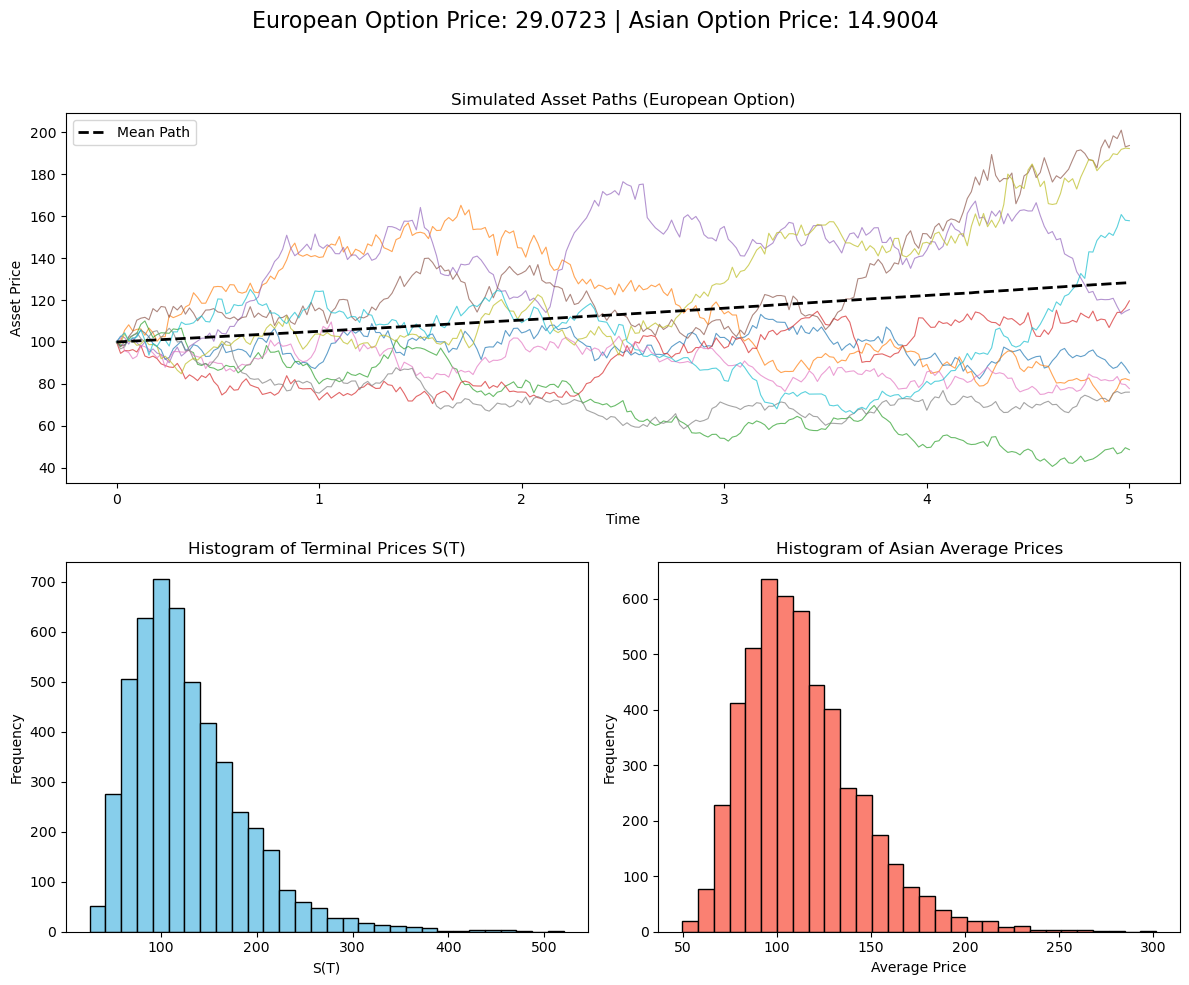

In [7]:
if __name__ == "__main__":
    mainCalculation()
